This notebook contains code of generating polygons that cover the global ocean
for the manuscript. <br>
It generates slight differetn polygons each time you run it.

In [1]:
import os
from glob import glob
import random
import gsw

import numpy as np
import xarray as xr
import pop_tools

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import gridspec
from matplotlib.image import imread

import cmocean
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull, Delaunay

# Generate polygons that cover the global ocean

## Get the grid ready: identify coastline and EEZ

Identify coastline in grid

In [3]:
def add_coast_mask(grid):
    
    '''Add coastline mask to POP grid
    
    Find coastline coordinates in POP grid: look for sharp gradient of KMT, first make 0 KMT to be 0.0001
    
    Key: calculate gradients between lon = 319 and nlon = 0 
    '''
    
    ocean_mask = (grid.KMT > 0).values

    # Replace zeros with 1e-4 using np.where()
    kmt = grid.KMT.values
    kmt_ = np.where(kmt == 0, 1e5, kmt)

    # Calculate the gradients in both dimensions
    gradient_x, gradient_y = np.gradient(kmt_)

    # Compute the magnitude of the gradients
    gradient_magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)

    # for nlon = 319, and nlon = 0, at the edge of POP grid
    grad_x, grad_y = np.gradient(kmt_[:, [0, 319]])
    gradient_edge = np.sqrt(grad_x ** 2 + grad_y ** 2)

    # Find the indices where the gradient magnitude exceeds the threshold
    coast_indices = np.where(gradient_magnitude > 40000)
    coast_indices_edge = np.where(gradient_edge > 40000)

    # conbime the 2 arrays
    coast_indices_edge_nlon = coast_indices_edge[1]
    coast_indices_edge_nlon[np.where(coast_indices_edge_nlon == 1)] = 319  # the 2nd column is 319
    whole_nlat = np.concatenate((coast_indices[0], coast_indices_edge[0]))
    whole_nlon = np.concatenate((coast_indices[1], coast_indices_edge_nlon))
    coast_indices = (whole_nlat, whole_nlon)

    # coastline mask in POP grid
    coast_mask = np.zeros(kmt.shape)
    for i in range(coast_indices[0].shape[0]):
        j = coast_indices[0][i] # nlat
        k = coast_indices[1][i] # nlon

        coast_mask[j,k] = 1

    coast_mask = coast_mask*ocean_mask
    grid['coast_mask'] = xr.DataArray(data=coast_mask, dims=['nlat', 'nlon'])
    
    return grid, coast_indices

Get POP grid, and add coastline mask

In [4]:
grid_name = 'POP_gx1v7'
grid = pop_tools.get_grid(grid_name)
grid, coast_indices = add_coast_mask(grid) # identify coastline indices in POP grid and add them to 

In [5]:
tlong = grid.TLONG.values
tlat = grid.TLAT.values

ocean_mask = (grid.KMT > 0).values # ocean mask as a numpy array
coastal_mask = grid['coast_mask'].astype(np.int32)  # coastline mask, this is in the ocean, not on land

Idensity EEZ, 370km from the coastline

In [9]:
def find_points_within_square(i, j, grid_shape, tol=2):
    
    '''To find points' indices that are within a square of length 4, centered at a given point (i, j)'''
    
    m, n = grid_shape
    # index of close points
    ind_x = []
    ind_y = []
    
    for x in range(max(0, i - tol*2), min(i + tol*2 + 1, m)):
        for y in range(max(0, j - tol), min(j + tol + 1, n)):
            #indices.append((x, y))
            ind_x.append(x)
            ind_y.append(y)
    
    return ind_x, ind_y

In [7]:
%%time
threshold_distance = 370  # in kilometers

# Create empty arrays for distances and region mask
region_mask_eez = np.zeros_like(coastal_mask)
region_mask_pools = np.zeros_like(coastal_mask)

# loop each coastline grid index, and find points in the ocean that are close to it
for i in range(coast_indices[0].shape[0]):
    coast_nlat =  coast_indices[0][i]
    coast_nlon =  coast_indices[1][i]
    
    #  1 coastal point coords
    point = [tlong[coast_nlat, coast_nlon], tlat[coast_nlat, coast_nlon]]

    # indices of the close points
    close_points_x, close_points_y = find_points_within_square(coast_nlat, coast_nlon, grid.TLONG.shape, 5)
    region_mask_pools[close_points_x, close_points_y] = 1 # the pools to select from
    
    # coordinates of the close points to be searched based on the distance
    tlong_close = tlong[close_points_x, close_points_y]
    tlat_close = tlat[close_points_x, close_points_y]
    
    # loop each caostal point, with a limited search domain, find EEZ
    for j in range(len(close_points_x)):
        if ocean_mask[close_points_x[j], close_points_y[j]]: # in the ocean
            if gsw.distance([tlong_close[j], point[0]],  [tlat_close[j], point[1]]) <= threshold_distance*1000: # within distance threshold
                region_mask_eez[close_points_x[j], close_points_y[j]] = 1

CPU times: user 1min 3s, sys: 4.66 ms, total: 1min 3s
Wall time: 1min 8s


You can also save the EEZ mask for future

In [10]:
grid['eez_mask'] = xr.DataArray(data=region_mask_eez, dims=['nlat', 'nlon'])
#grid.to_netcdf('./pop_grid_eez.nc', mode='w')

Selected EEZ grid points

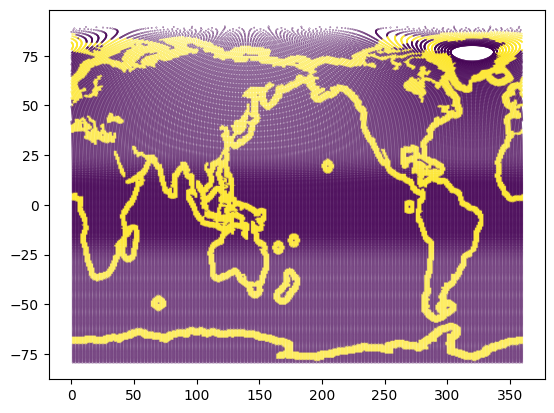

In [11]:
plt.scatter(tlong, tlat, c=region_mask_eez, s=0.05)

## Use K-means to generate polygons

Functions needed

In [155]:
def convert_longitudes(longitudes):
    '''Convert longitudes from (0,360) to (-180,180)'''
    
    converted_longitudes = np.where(longitudes > 180, longitudes - 360, longitudes)
    
    return converted_longitudes

def get_coords(mask_atlantic, convert_lon=True):
    '''Given an ocean mask, return the selected lon(-180,180) and lat
    convert_lon: to make longitude continuous, like Atlantic, but not Pacific
    '''
    
    # Find the indices of the atlantic ocean in the mask, extract lon, lat
    atlantic_indices = np.where(mask_atlantic == 1)

    # we need to conver longitude from a range of 0 - 360, to a range of -180 to 180. You can put it back after find all pacthes
    tlong_atlantic = tlong[atlantic_indices] 
    tlat_atlantic = tlat[atlantic_indices]
    if convert_lon == True:
        tlong_atlantic = convert_longitudes(tlong_atlantic)
    
    return tlong_atlantic, tlat_atlantic

def get_polygons(mask_atlantic, num_polygons, convert_lon=True, save_ind=False):
    
    '''Given ocean mask, and the number of clusters
    return Kmeans polygon_vertices, cluster_labels, cluster_centers
    convert_lon: to make longitude continuous, like Atlantic, but not Pacific'''
    
    #the selected lon and lat
    tlong_atlantic, tlat_atlantic = get_coords(mask_atlantic, convert_lon)

    np.random.seed(0)

    # construct data points
    data_points = np.vstack((tlong_atlantic, tlat_atlantic)).T # shape of (13563, 2)

    # Apply K-means clustering, run 30 times to get the best centroid
    kmeans = KMeans(n_clusters=num_polygons, n_init=30)
    kmeans.fit(data_points)
    cluster_labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_

    # Initialize empty lists to store triangle vertices
    polygon_vertices = [[] for _ in range(num_polygons)]
    polygon_ind_inAtlanticPOP = [[] for _ in range(num_polygons)] # store the index in Atlantic POP grid

    # Post-processing to form polygons
    for i, label in enumerate(cluster_labels):
        polygon_vertices[label].append(data_points[i])
        polygon_ind_inAtlanticPOP[label].append(i)

    polygon_vertices = np.array(polygon_vertices)  # all clusters' coordinates
    
    if save_ind:
        return polygon_vertices, polygon_ind_inAtlanticPOP, cluster_centers
    else:
        return polygon_vertices, cluster_centers


def plot_polygons(polygon_vertices, cluster_centers, lon_extend, lat_extend, remove=[], region='Atlantic', center_lon=0, save=False):    
        
    '''PLot polygons, given:
    polygon_vertices, cluster_centers: polygon coordinates, centers, 
    lon_extend, lat_extend: lon lat extends for plot
    remove: indices in the polygon to remove. You will run with [] to see which ones you want to remove, and run again with, such as [45,46] 
    center_lon=0 for Atlantic, and 180 for Pacific
    '''
    
    # remove some polygons 
    remove = [num - 1 for num in remove] # index in the plot is from 1
    polygon_vertices = np.delete(polygon_vertices, remove)
    cluster_centers = np.delete(cluster_centers, remove, axis=0) # remove rows

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=center_lon))
    ax.set_extent([*lon_extend, *lat_extend], crs=ccrs.PlateCarree())
    
    # a list of colors
    colors = list(mcolors.TABLEAU_COLORS.values())
    ind_color = np.arange(len(colors)) # 0- 9

    # loop each cluster
    for i in range(len(polygon_vertices)):
        vertices = np.array(polygon_vertices[i])
        if len(vertices) >= 3:
            hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
            polygon = list(vertices[i] for i in hull.vertices.tolist() )
            polygon = np.array(polygon)

            ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())
            #ax.fill(polygon[:, 0], polygon[:, 1], alpha=0.2, transform=ccrs.PlateCarree())

            ax.text(cluster_centers[i, 0]-1.8, cluster_centers[i, 1],str(i+1), fontsize=8, color='k', transform=ccrs.PlateCarree())
            ax.scatter(vertices[:, 0], vertices[:, 1], c=colors[random.choice(ind_color)], s=1, alpha=0.7, transform=ccrs.PlateCarree())

    ax.stock_img()
    ax.set_xticks(np.arange(lon_extend[0]+10, lon_extend[1], 30), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_extend[0]+10, lat_extend[1], 20), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)  

    ax.set_title(f'{region}, n={len(polygon_vertices)}')
    
    if save==True:
        plt.savefig(f'./figures/{region}_{len(polygon_vertices)}polygons.png', dpi=300, bbox_inches='tight')

def get_polygon_mask(tlong, mask_atlantic, polygon_ind_inAtlanticPOP):
    '''Return a mask for the polygon, given its vertexes
    tlong : POP grid
    '''
    
    # Find the indices of the atlantic ocean in the mask, extract lon, lat
    atlantic_indices = np.where(mask_atlantic == 1)
    
    a,b = tlong.shape
    n = len(polygon_ind_inAtlanticPOP) # number of patches
    
    # polygon mask
    polygon_mask = np.zeros((n,a,b))

    for i in range(n):  
        
        # indices of the polygon points in the Atlantic subset
        polygon_ind_inAtlanticPOP_54 = polygon_ind_inAtlanticPOP[i]

        # indices of selected polygon points in the original POP grid
        polygon_nlat = atlantic_indices[0][polygon_ind_inAtlanticPOP_54]
        polygon_nlon = atlantic_indices[1][polygon_ind_inAtlanticPOP_54]
        

        #  assign 1s
        for j in range(polygon_nlat.shape[0]):  # for each point in a polygon
            polygon_mask[i, polygon_nlat[j], polygon_nlon[j]] = 1

        if np.count_nonzero(polygon_mask[i]) != len(polygon_ind_inAtlanticPOP_54): # make sure the number of 1s in the mask == the number of vertexes in a patch
            print(f'Polygon {i} has different amount of 1s from the number of vertexes in the patch!')
    return polygon_mask

## Define region domains

Global ocean is divided into four domains (North Atlantic, North Pacific, South, Southern Ocean), which are further divided into 690 polygons.

In [156]:
def get_lat_range_mask(lat_min, lat_max):
    '''Return a mask over a range of latitudes'''

    region_mask_name = 'lat-range-basin'
    region_mask = pop_tools.region_mask_3d('POP_gx1v7', region_mask_name)
    keep = np.ones(region_mask.sizes['region']).astype(bool)
    for i in range(region_mask.sizes["region"]):
        region_mask.data[i, :, :] = xr.where(
            (region_mask[i, :, :] == 1.0) & (lat_min < grid.TLAT) & (grid.TLAT < lat_max), 1.0, 0.0
        )
        if not region_mask[i, :, :].any():
            keep[i] = False

    region_mask = region_mask[keep, :, :]
    
    return region_mask[0]

lat_10S90N_mask = get_lat_range_mask(-10, 90)
lat_10S75N_mask = get_lat_range_mask(-10, 75)
lat_10S70N_mask = get_lat_range_mask(-10, 70)
lat_60S0N_mask = get_lat_range_mask(-60, 0)
lat_90S50S_mask = get_lat_range_mask(-90, -50)

In [157]:
mask3d = pop_tools.region_mask_3d(grid_name, mask_name='default')
mask_atlantic =  mask3d.sel(region='Atlantic Ocean')*lat_10S90N_mask # Atlantic up to 10S
mask_GIN =  mask3d.sel(region='GIN Seas')*lat_10S75N_mask # GIN Sea uo to 75N
mask_LabSea =  mask3d.sel(region='Lab. Sea & Baffin Bay')*lat_10S70N_mask # Labrador Sea up t0 70N

# N. Pacific
mask_pacific =  mask3d.sel(region='Pacific Ocean')*lat_10S90N_mask # Pacific up to 10S

# N. Atlantic
mask_atlantic = np.logical_or(np.logical_or(mask_atlantic, mask_GIN), mask_LabSea)

In [158]:
mask_South_atlantic = mask3d.sel(region='Atlantic Ocean')*lat_60S0N_mask 
mask_South_pacific = mask3d.sel(region='Pacific Ocean')*lat_60S0N_mask 
mask_indian = mask3d.sel(region='Indian Ocean')
mask_southern = mask3d.sel(region='Southern Ocean')*lat_60S0N_mask 
# get rid of the overlap
overlap_atlantic = np.logical_and(mask_South_atlantic, mask_atlantic)
overlap_pacific = np.logical_and(mask_South_pacific, mask_pacific)
mask_South_atlantic = mask_South_atlantic - overlap_atlantic
mask_South_pacific = mask_South_pacific - overlap_pacific

# South
mask_south_atl_pac = np.logical_or(mask_South_pacific, mask_South_atlantic)
mask_south = np.logical_or(np.logical_or(mask_south_atl_pac, mask_indian), mask_southern)

# Southern Ocean
overlap = np.logical_and(mask_south, lat_90S50S_mask)
mask_Southern_Ocean = np.logical_not(overlap)*lat_90S50S_mask

Text(-178, -70, 'Southern Ocean')

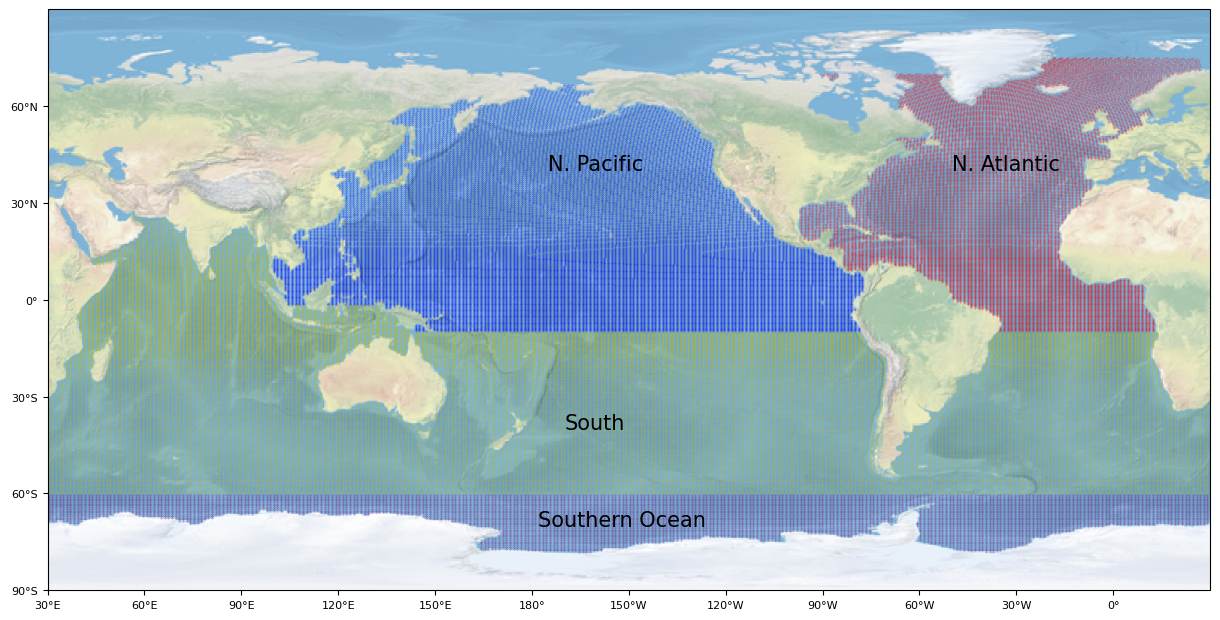

In [160]:
plt.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=210))
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# selected coastline in POP grid
ax.scatter(tlong[mask_atlantic==1], tlat[mask_atlantic==1], c='r', s=0.1, alpha=0.5, transform=ccrs.PlateCarree())
ax.scatter(tlong[mask_pacific==1], tlat[mask_pacific==1], c='b', s=0.1, alpha=0.5, transform=ccrs.PlateCarree())
ax.scatter(tlong[mask_south==1], tlat[mask_south==1], c='y', s=0.1, alpha=0.5, transform=ccrs.PlateCarree())
ax.scatter(tlong[mask_Southern_Ocean==1], tlat[mask_Southern_Ocean==1], c='purple', s=0.1, alpha=0.5, transform=ccrs.PlateCarree())

ax.set_xticks(np.arange(-180, 180, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 90, 30), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)  
ax.stock_img()

ax.text(-175, 40, 'N. Pacific', fontsize=15, transform=ccrs.PlateCarree())
ax.text(-50, 40, 'N. Atlantic', fontsize=15, transform=ccrs.PlateCarree())
ax.text(-170, -40, 'South', fontsize=15, transform=ccrs.PlateCarree())
ax.text(-178, -70, 'Southern Ocean',fontsize=15, transform=ccrs.PlateCarree())

## Clustering to form polygons

In [161]:
lon_extend = {'Atlantic': [-110, 30], 'Pacific': [90, 290], 'South': [-180, 180], 'Southern_Ocean': [-180, 180]}
lat_extend = {'Atlantic': [-40, 80], 'Pacific': [-30,80], 'South': [-90, 50], 'Southern_Ocean': [-90, -50], }

In [162]:
def visualization(mask_, num_poly, reg_name='Atlantic', convert_lon=False, cen_lon=180, close=False):
    '''
    Given target mask_, and number of polygons, generate the polygons and visualization
    
    Return: array of polygon masks
    '''
    polygon_vertices, polygon_ind_inAtlanticPOP, cluster_centers = get_polygons(mask_, num_poly, convert_lon=convert_lon, save_ind=True)
    # plot polygons
    plot_polygons(polygon_vertices, cluster_centers, lon_extend[reg_name], lat_extend[reg_name], remove=[], region=reg_name, center_lon=cen_lon, save=False)
    # The end product of polygon masks
    polygon_mask_EEZ = get_polygon_mask(tlong, mask_, polygon_ind_inAtlanticPOP)

    if close == True:
        plt.close()

    return polygon_mask_EEZ

North Atlantic - 100 in EEZ and 50 in open ocean

/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


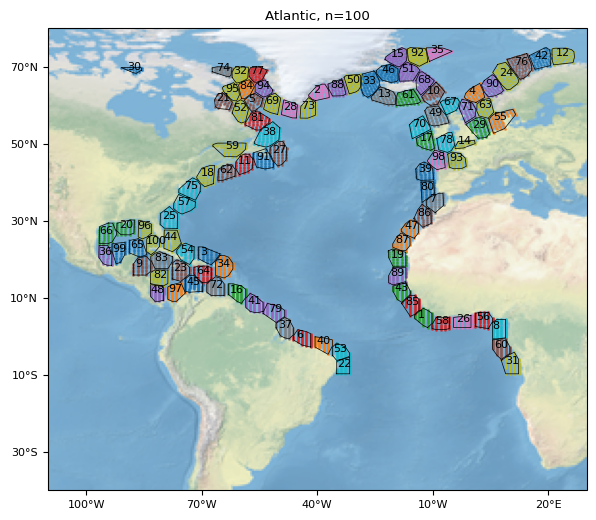

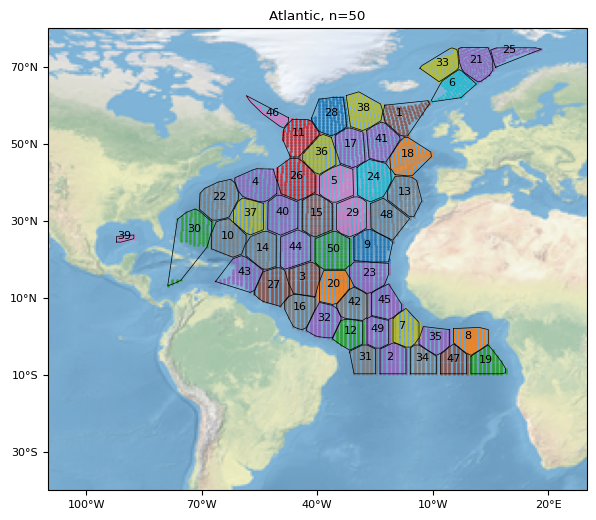

In [163]:
polygon_mask_EEZ_NAtlantic = visualization(mask_atlantic*region_mask_eez, 100, reg_name='Atlantic', convert_lon=True, cen_lon=0)
polygon_mask_open_ocean_NAtlantic = visualization(mask_atlantic*np.logical_not(region_mask_eez), 50, reg_name='Atlantic', convert_lon=True, cen_lon=0)

North Pacific - 90 in EEZ and 110 in open ocean

/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


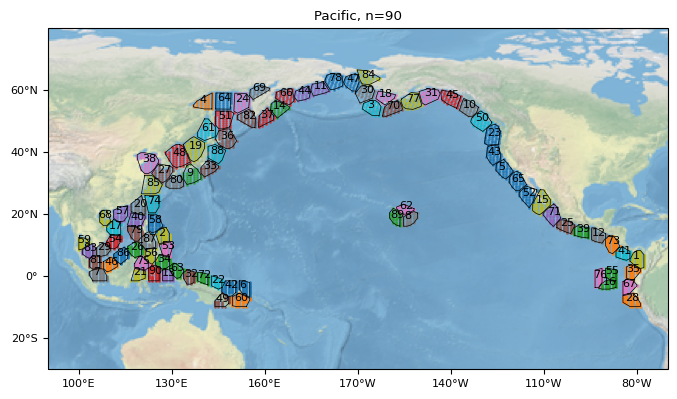

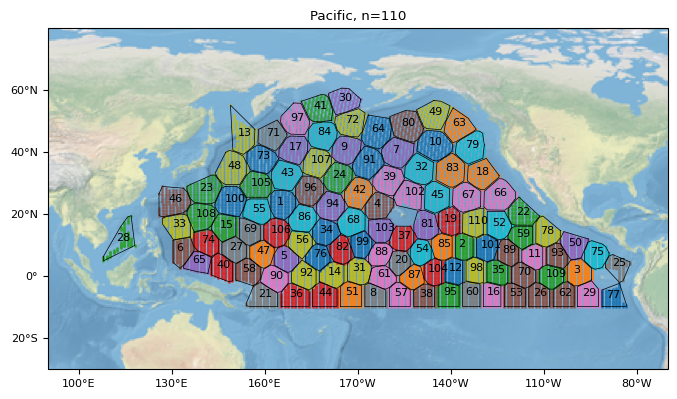

In [164]:
polygon_mask_EEZ_NPacific = visualization(mask_pacific*region_mask_eez, 90, reg_name='Pacific', convert_lon=False, cen_lon=180)
polygon_mask_open_ocean_NPacific = visualization(mask_pacific*np.logical_not(region_mask_eez), 110, reg_name='Pacific', convert_lon=False, cen_lon=180)

South - 120 in EEZ and 180 in open ocean

/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


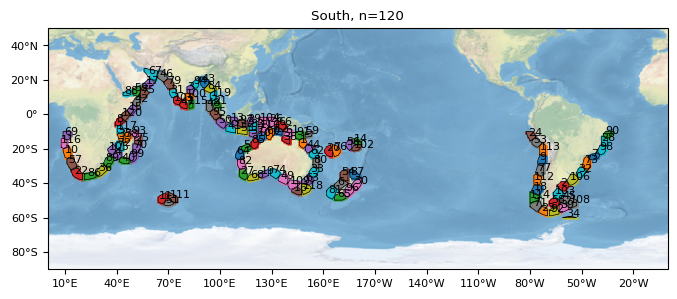

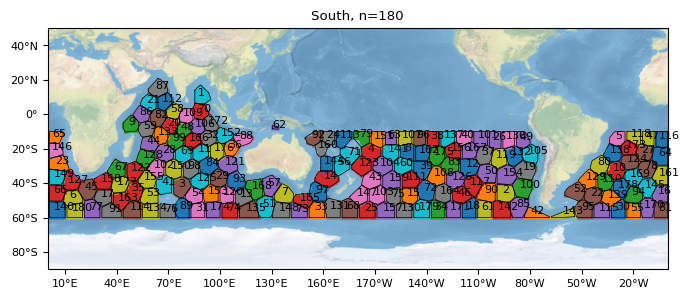

In [165]:
polygon_mask_EEZ_South = visualization(mask_south*region_mask_eez, 120, reg_name='South', convert_lon=False, cen_lon=180)
polygon_mask_open_ocean_South = visualization(mask_south*np.logical_not(region_mask_eez), 180, reg_name='South', convert_lon=False, cen_lon=180)

Southern Ocean - 40

/glade/work/mengyangz/miniconda3/envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


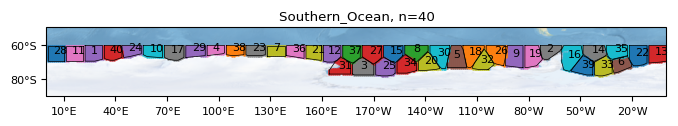

In [166]:
polygon_mask_Southern_Ocean = visualization(mask_Southern_Ocean, 40, reg_name='Southern_Ocean', convert_lon=False, cen_lon=180)

**Check THE END PRODUCT OF POLYGON MASKS**

In [128]:
arr_masks = [polygon_mask_EEZ_NAtlantic, polygon_mask_open_ocean_NAtlantic, polygon_mask_EEZ_NPacific, polygon_mask_open_ocean_NPacific, polygon_mask_EEZ_South, polygon_mask_open_ocean_South, polygon_mask_Southern_Ocean]

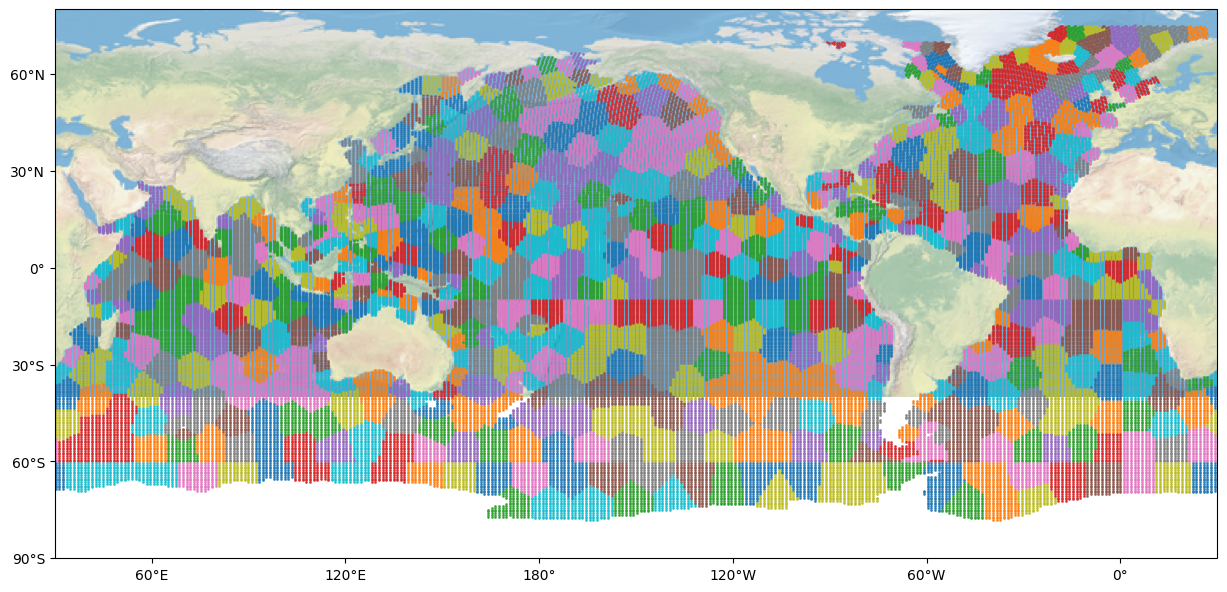

In [130]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=210))
ax.set_extent([-110,30, -40, 80], crs=ccrs.PlateCarree())
ax.stock_img()

# a list of colors
colors = list(mcolors.TABLEAU_COLORS.values())
ind_color = np.arange(len(colors)) # 0- 9

for arr_region_masks in arr_masks:
    for i in range(len(arr_region_masks)):
    
        # plot polygon masks
        index = np.where(arr_region_masks[i] == 1)
        ax.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.8, transform=ccrs.PlateCarree())

ax.set_xticks(np.arange(-180, 180, 60), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 90, 30), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)  

## Notes
1. The clusters are slightly different each time you run it.
2. You might want to get rid of some polygons, like the red one in father Noth of Canada.
3. You might want to combine some nearby polygons if they are too small to be considered as individual polygons.

# Fig. S4
The end product used in this study to simulate OAE in global ocean is as follows.

In [2]:
# pacific
final_polygon_mask_pacific = np.load('./polygon_data/Pacific_final_polygon_mask.npy')
final_polygon_vertices_pacific = np.load('./polygon_data/Pacific_final_polygon_vertices.npy', allow_pickle=True)
cluster_centers_pacific = np.load('./polygon_data/Pacific_final_cluster_centers.npy', allow_pickle=True)

# atlantic
final_polygon_mask_atlantic = np.load('./polygon_data/Atlantic_final_polygon_mask.npy')
final_polygon_vertices_atlantic = np.load('./polygon_data/Atlantic_final_polygon_vertices.npy', allow_pickle=True)
cluster_centers_atlantic = np.load('./polygon_data/Atlantic_final_cluster_centers.npy', allow_pickle=True)

# south
final_polygon_mask_south = np.load('./polygon_data/South_final_polygon_mask_120EEZ_180openocean.npy')
final_polygon_vertices_south = np.load('./polygon_data/South_final_polygon_vertices_120EEZ_180openocean.npy', allow_pickle=True)
cluster_centers_south = np.load('./polygon_data/South_final_cluster_centers_120EEZ_180openocean.npy', allow_pickle=True)

# southern ocean
final_polygon_mask_SO = np.load('./polygon_data/Southern_Ocean_final_polygon_mask.npy')
final_polygon_vertices_SO = np.load('./polygon_data/Southern_Ocean_final_polygon_vertices.npy', allow_pickle=True)
cluster_centers_SO = np.load('./polygon_data/Southern_Ocean_final_cluster_centers.npy', allow_pickle=True)

In [5]:
grid_name = 'POP_gx1v7'
grid = pop_tools.get_grid(grid_name)
tlong = grid.TLONG.values
tlat = grid.TLAT.values

CPU times: user 4.39 s, sys: 129 ms, total: 4.51 s
Wall time: 4.71 s


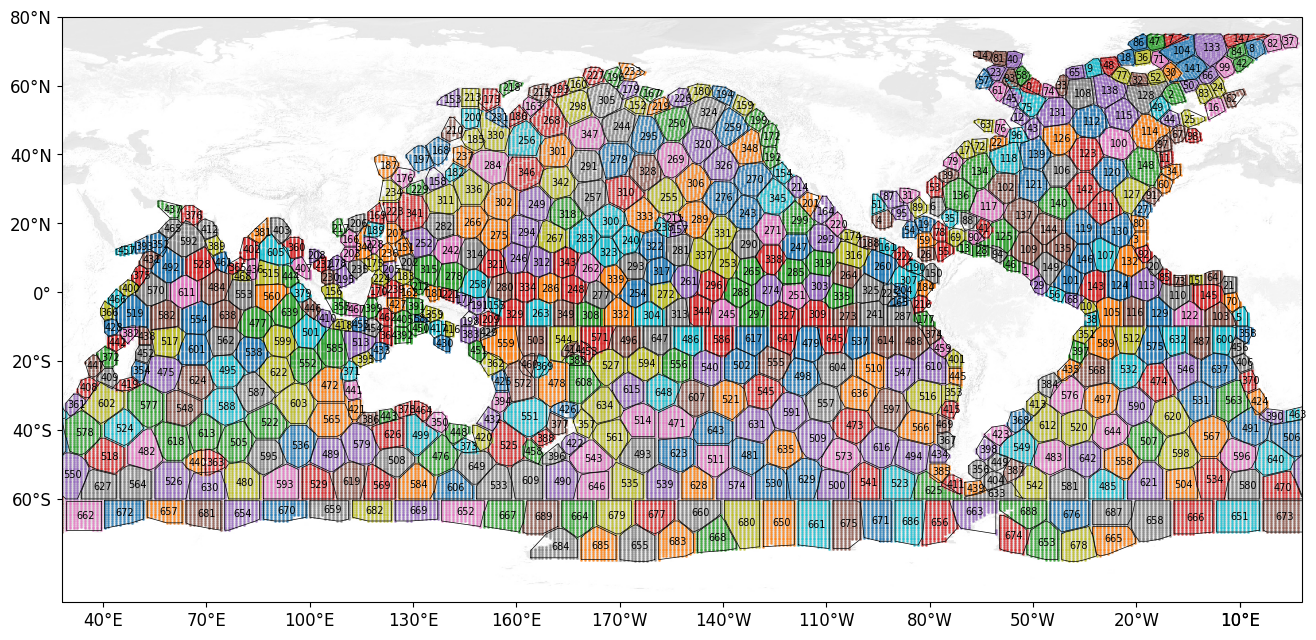

In [6]:
%%time
plt.rcParams.update({'font.size': 24})
fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=208))
ax.set_extent([0, 360, -90, 80], crs=ccrs.PlateCarree())
ax.tick_params(axis='both', labelsize=24)
ax.imshow(imread('./lightearth.jpg'),origin='upper', transform=ccrs.PlateCarree(), extent=[-180, 180, -90, 90])
#ax.stock_img()

# a list of colors
colors = list(mcolors.TABLEAU_COLORS.values())
ind_color = np.arange(len(colors)) # 0- 9

def plot_polygons(final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, offset=0):
    for i in range(len(final_polygon_mask_atlantic)):
        vertices = np.array(final_polygon_vertices_atlantic[i])
        # plot convex hull
        if len(vertices) >= 3:
            hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
            polygon = list(vertices[i] for i in hull.vertices.tolist() )
            polygon = np.array(polygon)

            ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())

        # plot polygon masks
        index = np.where(final_polygon_mask_atlantic[i] == 1)
        ax.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.6, transform=ccrs.PlateCarree())
        ax.text(cluster_centers_atlantic[i, 0]-2, cluster_centers_atlantic[i, 1]-1, str(i+offset), fontsize=7, color='k', transform=ccrs.PlateCarree())

plot_polygons(final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic)
plot_polygons(final_polygon_mask_pacific,final_polygon_vertices_pacific, cluster_centers_pacific, offset=150)
plot_polygons(final_polygon_mask_south, final_polygon_vertices_south, cluster_centers_south, offset=150+200)
plot_polygons(final_polygon_mask_SO, final_polygon_vertices_SO, cluster_centers_SO, offset=150+200+300)

ax.set_xticks(np.arange(10, 400, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-60, 100, 20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter) 

ax.tick_params(axis='both', which='major', labelsize=12)

#plt.savefig('./Global_Forcing_reindex.png', dpi=400, bbox_inches='tight')

# Fig. S5
Distribution of polygon areas in EEZ and open ocean

In [7]:
def get_area_from_mask(mask_atl, centers_atl):
    
    mask_atl = xr.DataArray(mask_atl, dims=('region', 'nlat', 'nlon'), coords={'region': np.arange(0,mask_atl.shape[0])})
    #mask_atl.attrs['mask_name'] = 'North_Atlantic_basin'
    area_atl = mask_atl*grid.TAREA/(1e10) # km^2
    
    # sum of all areas
    area_atl_sum = area_atl.sum(dim={'nlat', 'nlon'}) 
    # number of grid points
    count_num = area_atl.where(area_atl != 0).count(dim={'nlat', 'nlon'})
    
    return area_atl_sum, count_num

In [8]:
area_atl, count_atl = get_area_from_mask(final_polygon_mask_atlantic, cluster_centers_atlantic)
area_pac, count_pac = get_area_from_mask(final_polygon_mask_pacific, cluster_centers_pacific)
area_south, count_south = get_area_from_mask(final_polygon_mask_south, cluster_centers_south)
area_SO, count_SO = get_area_from_mask(final_polygon_mask_SO, cluster_centers_SO)

In [11]:
area_EEZ = np.concatenate((area_atl[:100].values, area_pac[:90].values, area_south[:120].values))
area_open_ocean = np.concatenate((area_atl[100:].values, area_pac[90:].values, area_south[120:].values, area_SO.values))

center_EEZ = np.concatenate((cluster_centers_atlantic[:100], cluster_centers_pacific[:90], cluster_centers_south[:120]))
center_open_ocean = np.concatenate((cluster_centers_atlantic[100:], cluster_centers_pacific[90:], cluster_centers_south[120:], cluster_centers_SO))

count_EEZ = np.concatenate((count_atl[:100], count_pac[:90], count_south[:120]))
count_open_ocean = np.concatenate((count_atl[100:], count_pac[90:], count_south[120:], count_SO))

Text(-300000.0, 129, 'b')

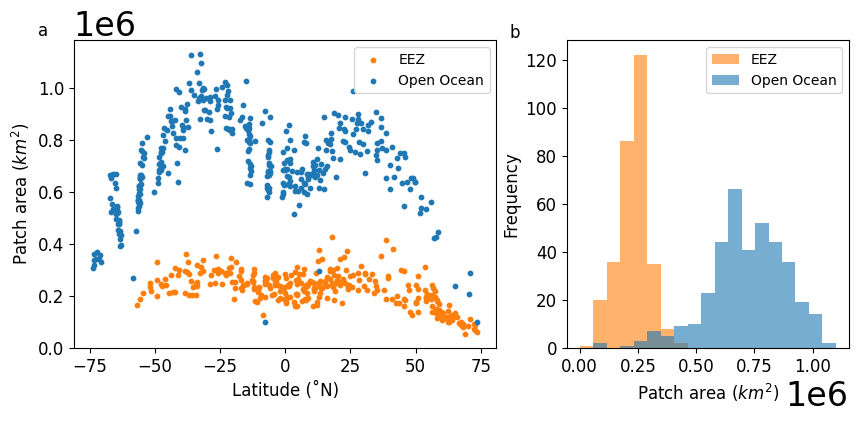

In [12]:
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1])  # Adjust the width ratios as needed

ax = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# histogram
bins=np.linspace(0, 1.1e6, 20)
ax1.hist(area_EEZ, bins=bins, alpha=0.6, label='EEZ', color='C1')
ax1.hist(area_open_ocean, bins=bins, alpha=0.6, label='Open Ocean', color='C0')

# scatter
ax.scatter(center_EEZ[:, 1], area_EEZ, s=10, marker='o', facecolors='C1', edgecolors='C1', label='EEZ')
ax.scatter(center_open_ocean[:, 1], area_open_ocean, s=10, marker='o', facecolors='C0', edgecolors='C0', label='Open Ocean')

FONTSIZE=12
ax.set_xlabel('Latitude (˚N)', fontsize=FONTSIZE)      
ax.set_ylabel('Patch area ($km^2$)', fontsize=FONTSIZE)      

ax1.set_xlabel('Patch area ($km^2$)', fontsize=FONTSIZE)      
ax1.set_ylabel('Frequency', fontsize=FONTSIZE)      

def modify(ax):
    ax.tick_params(axis='x', labelsize=FONTSIZE)
    ax.tick_params(axis='y', labelsize=FONTSIZE)
    
modify(ax)
modify(ax1)

ax.legend(fontsize=FONTSIZE-2)               
ax1.legend(fontsize=FONTSIZE-2)    

ax.text(-95, 1.2e6, 'a', fontsize=FONTSIZE)
ax1.text(-0.3e6, 129, 'b', fontsize=FONTSIZE)

#plt.savefig('./polygon_area_distribution.png', dpi=200, bbox_inches='tight')